# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">ML Interpretability - Shapley Values &amp; SHAP</p>

In [82]:
# %load ../general_settings.py
import os
import shutil
import subprocess
import warnings
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
if ON_KAGGLE:
    warnings.filterwarnings("ignore")

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.core.display import HTML, display_html
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

from shap import explainers, maskers
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

FONT_COLOR = "#2F486B"
BACKGROUND_COLOR = "#FFFCFA"

CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #FCFCFC",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #3E3F4C; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-style: italic; background-color: #2F486B; color: #FCFCFC;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-style: italic; background-color: #2F486B; color: #FCFCFC;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#D4D0A9", as_cmap=True)

# Utility functions.
def download_dataset_from_kaggle(user, dataset, directory):
    command = "kaggle datasets download -d "
    filepath = directory / (dataset + ".zip")
    if not filepath.is_file():
        subprocess.run((command + user + "/" + dataset).split())
        filepath.parent.mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(dataset + ".zip", "data")
        shutil.move(dataset + ".zip", "data")


def download_competition_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")
    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


def interpolate_color(color1, color2, t):
    r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
    r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
    r = int(r1 + (r2 - r1) * t)
    g = int(g1 + (g2 - g1) * t)
    b = int(b1 + (b2 - b1) * t)
    return f"#{r:02X}{g:02X}{b:02X}"


def get_interpolated_colors(color1, color2, num_colors=2):
    """Return `num_colors` interpolated beetwen `color1` and `color2`.
    Arguments need to be HEX."""
    num_colors = num_colors + 2
    return [interpolate_color(color1, color2, i / (num_colors - 1)) for i in range(num_colors)]


# Html `code` block highlight. Must be included at the end of all imports!
HTML(
    """
<style>
code {
    background: rgba(42, 53, 125, 0.10) !important;
    border-radius: 4px !important;
}
</style>
"""
)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notebook Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    This notebook aims to present machine learning models' interpretability and explainability using the so-called <b>Shapley values</b> and <code>shap</code> library. The <code>shap</code> library will be depicted in both regression and classification problems. We will use some easy datasets like as <b>Titanic</b> and <b>House Prices</b>. 
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>This Notebook Covers</b> 📔
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <li>Explanation of Shapley values in machine learning.</li>
    <li>Interpretability of features influence within SHAP.</li>
    <li>The answer to the question of why the model taken up such and not another decision.</li>
</ul>

</blockquote>

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">Shapley Values</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Can you explain why your model predicts such and not another value?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Can you answer this question? If not, <b>SHAP (SHapley Additive exPlanations)</b> is something for you. I found out about <b>SHAP</b> maybe a week before this notebook was published. I noticed that in several notebooks but without any explanations. Therefore, I was just curious about what is that library and how to utilise it to better understand my models.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Shapley values introduction</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Let's get started from the beginning. Generally, <b>SHAP</b> is a specific approach that helps you understand and explain your model's individual predictions. That method is based on <b>Shapley's values</b> from cooperative game theory. The point is that, we can consider prediction process as a game where certain features are players and prediction is a gain. <b>SHAP</b> tells us how to distribute the contribution of each feature into certain prediction fairly. So, what exactly is a Shapley value? Well, it's an <b>average marginal contribution of a feature value across all possible coalitions of features.</b> Understandable? Of course, not. Let me explain this step by step.<br>
    Let's suppose we need to build a machine learning model which has to predict house prices considering different attributes like median house age or number of rooms. Assume we have only four features to make it as easy as possible. These are the <code>HouseAge</code> (median house age in block group), <code>AveRooms</code> (average number of rooms per household), <code>AveOccup</code> (average number of household members), and <code>Population</code> (block group population). These features are a subset of the California housing dataset from <code>scikit-learn</code>, which we will use later. Okay, so we've just built such a model, and it turns out that the average house price is $200,000$. After that, we test it on a test dataset. We take a new sample and must predict its price. We get $250,000$, and somebody could ask us why there is such a difference? <b>More precisely, how much each feature of this certain observation contributes to the prediction compared to the average price?</b><br>
    In the case of linear models, the answer is easy, i.e. the prediction is just the sum of the weight of each feature times the feature value plus intercept. Weights and intercept are found by minimizing the cost function. Nevertheless, in the case of boosted trees or neural networks, the answer is a challenge. For such cases, the problem of model explainability is solved by a method from cooperative game theory - this is the place where <b>SHAP</b> comes into play. It explains the difference between specific prediction and average prediction (made for the whole dataset, for example, the training one).
</p>

<figure>
    <center>
        <img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/shap_shapley_values/example.png" width=600px>     
    <center>
    <figcaption>
        <p style="font-size: 16px; font-family: 'JetBrains Mono'; color: #2F486B; margin-left: 15px; margin-right: 15px">The average house price for the training dataset is $200,000$, but for the new observation, it's $250,000$. The explanation may be something like that: house age ($80$) contributes $+20,000$, rooms (five) contribute $+40,000$, and population (six) contributes $-10,000$. In total, these features contribute $+50,000$ to the average price.</p>.
    </figcaption>
    </center>
</figure>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>How to calculate Shapley value?</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Calculation of Shapley value for a specific feature is based on coalitions of features. Let's get back to the example with house prices, and suppose we want to calculate the Shapley value for a <code>HouseAge</code> feature for a specific sample (Shapley value is associated with a specific sample and specific feature). Firstly, consider the coalition of <code>AveRooms</code> and <code>Population</code>. As we want to assess the contribution of <code>HouseAge</code> (for example $30$ for this observation), we take values of these three features for that sample and randomly pick some value for the <code>AveOccup</code> from another sample. We evaluate the model and get a prediction of $220,000$. After that, we remove <code>HouseAge</code> from the coalition by picking the value for that feature from the sample drawn earlier (let's say <code>HouseAge</code> is $40$ there). We re-evaluate the model and get $200,000$. The contribution of <code>HouseAge</code> component is +$20,000$ in this case. These calculations depend on randomly drawn samples, and we should perform many test iterations to get a more reliable result. Moreover, we repeat this calculation for all possible coalitions of features. These coalitions are:
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <li>No coalition of features.</li>
    <li><code>AveRooms</code>.</li>
    <li><code>AveOccup</code>.</li>
    <li><code>Population</code>.</li>
    <li><code>AveRooms</code>, <code>AveOccup</code>.</li>
    <li><code>AveRooms</code>, <code>Population</code>.</li>
    <li><code>AveOccup</code>, <code>Population</code>.</li>
    <li><code>AveRooms</code>, <code>AveOccup</code>, <code>Population</code>.</li>
</ul>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
For all of these coalitions, we compute the predicted price, with and without feature <code>HouseAge</code> value and take marginal contribution as the difference between prices. Let me illustrate this with example of California housing dataset.
</p>

</blockquote>

In [31]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Let's take only four features.
features = ["HouseAge", "AveRooms", "Population", "AveOccup"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X[features], y, test_size=0.1, random_state=42
)

scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

model = LinearRegression().fit(X_train, y_train)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>What we exactly want to do?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    We want to calculate the Shapley value for a specific sample from the validation dataset by hand and then compare it to the Shapley value obtained from <code>shap</code> library. In this case, we want to explain contribution of <code>HouseAge</code> (which is the first feature - $0$). Therefore, we fetch an example dataset and take only four features (just for ease of use). Then we split this dataset into training and validation ones and fit the ordinary linear model. After that, we define a sample number from the validation dataset and a number of the feature. <b>For this certain sample and feature, we want to calculate the Shapley value. To do that, we need to create all coalitions of features without that certain one, we examine.</b>
</p>
</blockquote>

In [59]:
sample_no = 0  # Number of sample from valid dataset.
feature_no = 0  # Number of feature, that contribution we want to explain.
n_features = len(X_train.columns)

feature_ids = list(range(n_features))
feature_ids.remove(feature_no)

nested_combs = list(list(combinations(feature_ids, r)) for r in range(0, n_features))
features_combs = np.array(list(chain(*nested_combs)), dtype=object)
all_features = np.arange(n_features)

print(CLR + "All possible coalitions of features (without `HouseAge`)")
print(RED + "=>", *features_combs)


All possible coalitions of features (without `HouseAge`)
=> () (1,) (2,) (3,) (1, 2) (1, 3) (2, 3) (1, 2, 3)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Monte Carlo estimation of Shapley value</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In the case of a large number of features, the calculation for all coalitions is complex. However, there is an approximate method for that, based on <b>Monte-Carlo sampling</b>. This method calculates Shapley value for certain feature $j$ and certain sample $x$:
    \[\hat{\phi}_j(x) = \frac{1}{N}\sum_{n=1}^N \left[\hat{f}(x_{+j}^n) - \hat{f}(x_{-j}^n)\right]\] where $N$ is the number of sampling steps, $\hat{f}(x_{+j}^n)$ is the prediction for sample $x$ in the step $n$, where the part of feature values from this sample has been replaced by values from randomly picked observation, but value of feature $j$ still comes from $x$. The second part: $\hat{f}(x_{-j}^n)$, is similar to the first one but value of feature $j$ is replaced by value from that randomly chosen observation.<br>
    Pseudo algorithm that calculates Shapley value:
    <b>
    <ol style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #2F486B;
        margin-left: 15px;
        margin-right: 15px;
    ">
        <li>Choose a specific observation $x$, a specific feature $j$, and a number of sampling $N$.</li>
        <li>For each $n$ in $N$:</li>
        <ol style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
            color: #2F486B;
            margin-left: 15px;
            margin-right: 15px;
        ">
            <li>Draw a random sample $z$ and a random subset of features (coalitions) for sample $x$.</li>
            <li>Create a new sample $v$, where values of features related to $x$ are taken from $x$, and the rest values of features are taken from $z$.</li>
            <li>Create two new samples $v_p$ and $v_m$ by copying $v$. In the sample, $v_p$ replace the value of feature $j$ with a value of that feature from sample $x$, and in $v_m$ replace the value of feature $j$ with a value of that feature from sample $z$.</li>
            <li>Calculate marginal distribution: $model(v_p)$ - $model(v_m)$, and store it.</li>
        </ol>
        <li>Average all marginal contributions by dividing by $N$. You've just obtained the approximate Shapley value for sample $x$ and feature $j$.</li>
    </ol>
    </b>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In our case, we have only four features, so all combinations are calculable in a short time, so we perform something between Monte-Carlo sampling and direct calculation.
</p>
</blockquote>

In [61]:
np.random.seed(42)

n_iterations = 1000
marginal_contributions = np.zeros(n_iterations)

for i in range(n_iterations):
    random_no = np.random.randint(len(X_train))

    x_features = np.array(np.random.choice(features_combs))  # Coalitions
    z_features = np.setdiff1d(all_features, x_features)  # Feature values from random observation.

    x = X_valid.iloc[sample_no, x_features]  # Sample we examine.
    z = X_train.iloc[random_no, z_features]  # Random sample, which serves as a donor.

    sample = pd.DataFrame({**x.to_dict(), **z.to_dict()}, index=[0])[X_valid.columns]

    sample_p_j = sample.copy()  # Sample with original value of feature `j`.
    sample_m_j = sample.copy()  # Sample with replaced value of feature `j`.

    sample_p_j.iloc[:, feature_no] = X_valid.iloc[sample_no, feature_no]
    sample_m_j.iloc[:, feature_no] = X_train.iloc[random_no, feature_no]

    marginal_contributions[i] = model.predict(sample_p_j) - model.predict(sample_m_j)

print(CLR + "Shapley value by hand:", RED + f"{marginal_contributions.mean():.5f}")


Shapley value by hand: -0.04785


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Okay, we got some value, but does it have any sense? We need to compare it with the output from the <code>shap</code> library. In the bottom cell, we define a new linear explainer (as we used a linear model for training). We pass there the model and something like the shap library calls a masker, that is used to <i>train</i> the explainer.
</p>
</blockquote>

In [62]:
masker = maskers.Independent(X_train, max_samples=len(X_train))
explainer = explainers.Linear(model, masker)
shap_values = explainer(X_valid.iloc[[sample_no], :])

print(CLR + "SHAP Output:\n")
print(shap_values, "\n")
print(CLR + "Shapley value from SHAP library:", RED + f"{shap_values.values[0, feature_no]:.5f}")


SHAP Output:

.values =
array([[-0.04669537, -0.09805405, -0.00112126, -0.00220943]])

.base_values =
array([2.06861739])

.data =
array([[-0.28671279, -0.49353058, -0.03075389,  0.0726769 ]]) 

Shapley value from SHAP library: -0.04670


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Observations</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Using <code>shap</code> library, the Shapley value is hidden in the <code>values</code> attribute of the explainer. We analyse the first feature, so it's the first value of that array. The remaining attributes are: <code>base_values</code>, which means the average prediction for the given dataset, and <code>data</code>, which is exactly the array of our examined sample. As you can see, perhaps the result calculated by hand is not a world champion, but these results are comparable. I checked several different configurations, and these values follow each other.<br>
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Shapley value properties</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Shapley value interpretation may be confusing. <b>The interpretation is that the value of feature $j$ contributed in different coalitions by $\hat{\phi}_j(x)$ to the prediction for this specific observation, in comparison to the average prediction.</b> It's not the difference between predictions when we remove this feature from the dataset. Shapley value fulfills four axioms. These are:
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <li><b>Efficiency</b> - feature contributions must sum up to the difference of sample prediction and average prediction (see code below).</li>
    <li><b>Symmetry</b> - if two fature values equally contribute in all coalitions, then contribution of these should be equal.</li>
    <li><b>Dummy</b> - the Shapley value of the feature value is equal to zero if it doesn't change anything during prediction in different coalitions.</li>
    <li><b>Additivity</b> - in the example of a random forest - if we calculate the Shapley value for each tree individually, average it and then calculate the Shapley value for a random forest, they are the same.</li>
</ul>
</p>
</blockquote>

In [38]:
avg_prediction = model.predict(X_train).mean()
print(CLR + "Average model prediction for valid dataset:", RED + f"{avg_prediction:.5f}")


Average model prediction for valid dataset: 2.06862


In [39]:
sample_prediction = model.predict(X_valid.iloc[[sample_no], :])[0]
print(CLR + "Model prediction for chosen sample:", RED + f"{sample_prediction:.5f}")


Model prediction for chosen sample: 1.92054


In [40]:
print(
    CLR + "Sum of average prediction and all Shapley values:",
    RED + f"{avg_prediction + shap_values.values.sum():.5f}",
)


Sum of average prediction and all Shapley values: 1.92054


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>What is Shapley value?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>The Shapley value is the average marginal contribution of a feature value across all possible coalitions of features.</b><br>
    Understandable? I hope so.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Quick Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    That's all that I wanted to present about Shapley's values. I hope you found out something new. For me, it's a completely new topic so I tried to pass it on best I can. I hope there are no mistakes, but if you are familiar with this you can let me know in the comments section. Then, I will try to fix if something is wrong.<br><br>
    <b>References:</b><br>
    <ul style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #2F486B;
        margin-left: 15px;
        margin-right: 15px;
    ">
        <li><a href="https://arxiv.org/abs/1705.07874" style="color: #C94040;"><b>A Unified Approach to Interpreting Model Predictions</b></a></li>
        <li><a href="https://christophm.github.io/interpretable-ml-book/shapley.html" style="color: #C94040;"><b>Shapley Values</b></a></li>
        <li><a href="https://christophm.github.io/interpretable-ml-book/shap.html" style="color: #C94040;"><b>SHAP (SHapley Additive exPlanations)</b></a></li>
    </ul>
</p>

</blockquote>

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">SHAP in Action</p>

<figure>
    <center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/shap_shapley_values/shap_header.png" alt="SHAP" width=640px></center></br>
    <center><figcaption><b style="font-size: 16px; font-family: 'JetBrains Mono'; color: #2F486B">Explanation by SHAP. Source: <a href="https://shap.readthedocs.io/en/latest/" style="color: #C94040">SHAP documentation</b></a>.</figcaption></center>
</figure>


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The <code>shap</code> library is based on a game theoretic approach - Shapley values (and their extensions) to explain any machine learning model (from simple linear regression up to neural networks). In this section, we will see how <code>shap</code> handles with models' output explainability. We are starting with the regression problem. For this purpose, we're using <b>House Prices dataset</b>. Firstly, let's load that.
</p>
</blockquote>

In [84]:
competition = "house-prices-advanced-regression-techniques"

if not ON_KAGGLE:
    download_competition_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

house_prices_train = pd.read_csv(train_path, index_col="Id")
house_prices_test = pd.read_csv(test_path, index_col="Id")


In [85]:
house_prices_train.head().style.set_table_styles(DF_STYLE)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In this dataset, we are almost eighty different features, but we won't be using all of them, and select only several. Moreover, we need some easy preprocessing for encoding and handling missing values. 
</p>
</blockquote>

In [86]:
auto_preprocess = make_column_transformer(
    (
        SimpleImputer(strategy="median"),
        make_column_selector(dtype_include="number"),  # type: ignore
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OrdinalEncoder(),
        ),
        make_column_selector(dtype_include="object"),  # type: ignore
    ),
    verbose_feature_names_out=False,
).set_output(transform="pandas")

feature_names = [
    "LotArea",
    "OverallQual",
    "YearBuilt",
    "TotalBsmtSF",
    "GrLivArea",
    "BedroomAbvGr",
    "GarageCars",
    "GarageArea",
]

X_house_prices_train = auto_preprocess.fit_transform(house_prices_train[feature_names])
y_house_prices_train = house_prices_train["SalePrice"]

X_house_prices_test = auto_preprocess.transform(house_prices_test[feature_names])


In [87]:
X_house_prices_train.head().style.set_table_styles(DF_STYLE).format(precision=0)


,LotArea,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,BedroomAbvGr,GarageCars,GarageArea
Id,,,,,,,,
1,8450,7,2003,856,1710,3,2,548
2,9600,6,1976,1262,1262,3,2,460
3,11250,7,2001,920,1786,3,2,608
4,9550,7,1915,756,1717,3,3,642
5,14260,8,2000,1145,2198,4,3,836


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    I provided simple filling of missing values with median strategy and encoding within the ordinal encoder. The task is easy here, i.e. train a machine learning model to predict the price of the house (in dollars). After the preprocessing is done, we're ready to train some basic model. For this case, I will choose <code>RandomForestRegressor</code> with <code>min_samples_leaf=8</code>. 
</p>
</blockquote>

In [88]:
tree_model = RandomForestRegressor(
    random_state=42,
    min_samples_leaf=8,
).fit(X_house_prices_train, y_house_prices_train)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The model is ready to make predictions. Now we need to build an explainer, which will be able to show us how the random forest takes decisions. <b>To do that we're using tree explainer, which is adapted to models based on trees.</b>
</p>
</blockquote>

In [146]:
tree_explainer = shap.explainers.Tree(
    tree_model,
    data=X_house_prices_train,  # Background dataset.
    model_output="raw",  # Explain raw output of the model (output of the predict method).
    feature_perturbation="interventional",  # Or "tree_path_dependent".
    feature_names=feature_names,
)

# Let's explain predictions for 100 test observations.
shap_values = tree_explainer(X_house_prices_test[:100])


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>General Remarks</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    We need to stop for a while at this moment. Primarily we've built an explainer as earlier, but this is adapted to tree-based models, so this step is rather logical. Secondly, we want to explain the prediction for the new sample we provide. Therefore, we set <code>raw</code> as the <code>model_output</code> argument. It causes the explainer focuses on output from the <code>predict()</code> method of the model. The <code>feature_names</code> parameter should be understandable. It's just for tracing feature names. Well, remain one parameter which demands a longer explanation - <code>feature_perturbation</code>.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Feature Perturbation</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In the tree explainer, we can choose between <code>interventional</code> and <code>tree_path_dependent</code> options in <code>feature_perturbation</code>. What does it all mean? Well, let's quote the original Lundberg paper (<a href="https://arxiv.org/abs/1705.07874" style="color: #C94040;"><b>A Unified Approach to Interpreting Model Predictions</b></a>):<br>
    <b><i>Shapley values are computed by introducing each feature, one at a time, into a conditional expectation function of the model's output, $f_x(S) = E[f(X)│do(X_S=x_S)]$, and attributing the change produced at each step to the feature that was introduced; then averaging this process over all feature orderings.</i></b><br>
    Now, let's explain that. In general, the notation $E[f(X)│do(X_S=x_S)]$ denotes the conditional expectation when we intervene that $X_S=x_S$ (instead of observing that $X_S=x_S$). In other words, we know the values of the features in S (a subset of features) because we set them. The subset $X_S$ is the coalition of features. It means that we know the values of these features for the observation $x$. Okay, so we know the coalition of features values. But what with missing subset features $X_C$? It turns out that the absence of features' values is simulated by taking values from the background dataset. Therefore, when we use <code>interventional</code> feature perturbation, we need to provide a background dataset. On the other hand, in the case of <code>tree_path_dependent</code>, the background dataset is not required because the explainer is able to infer background distribution from the model structure. The crucial difference between <code>interventional</code> and the <code>tree_path_dependent</code> methods is that there is an assumption in the interventional approach that $X_S$ and $X_C$ are independent, meaning that the value of one feature does not depend on the value of another feature, as I understand. I refer to <a href="https://arxiv.org/abs/1910.13413" style="color: #C94040;"><b>Feature relevance quantification in explainable AI: A causal problem</b></a> if you are interested.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Enough Theory</b> 📈
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Well, I think there is enough theory, and now let's have some fun with visuals. Let's get started with <code>force</code> plots.
</p>

</blockquote>

Number of test sample: 23


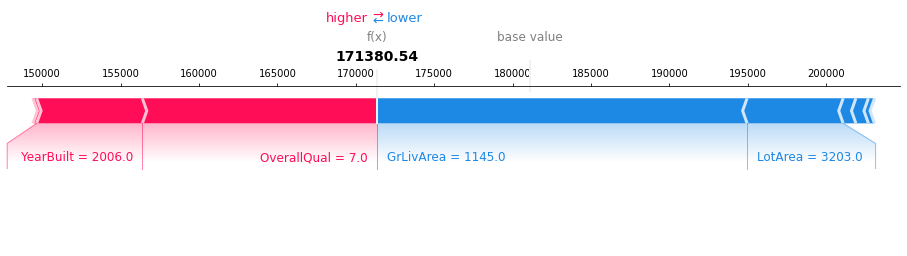

Number of test sample: 24


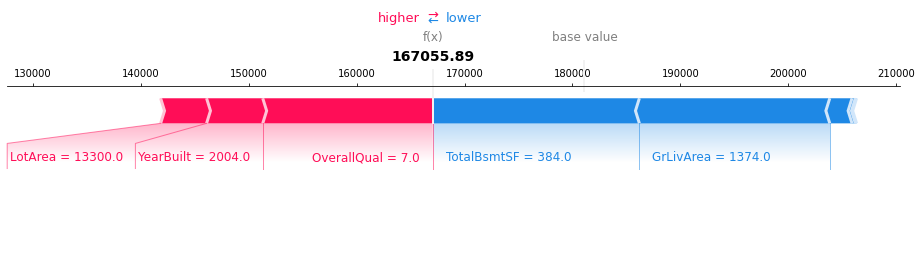

Number of test sample: 25


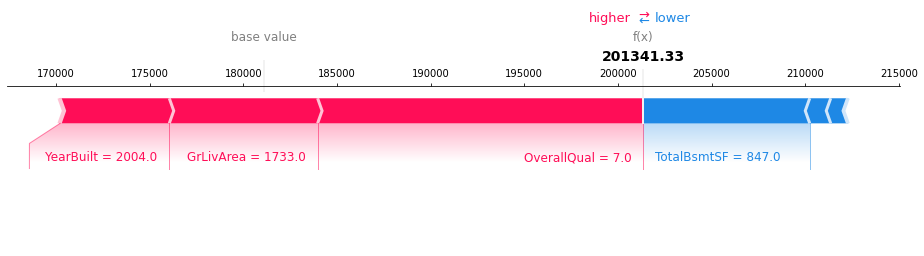

In [74]:
for sample_no in np.arange(23, 26):
    print(CLR + "Number of test sample:", RED + str(sample_no))
    shap.plots.force(
        tree_explainer.expected_value,
        shap_values.values[sample_no],
        features=X_house_prices_test.iloc[[sample_no]].round(2),
        feature_names=feature_names,
        matplotlib=True,
        figsize=(16, 3),
    )


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Force Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The three plots you see above are so-called <code>force</code> plots. <b>Force plot depicts feature contributions (Shapley values) as forces, where each feature can increase or decrease the prediction result</b>. In such a plot, the prediction starts from the baseline, which is the average prediction for the dataset. Red arrows push prediction to higher values, meanwhile blue arrows, on the other way around. <b>Remember that these plots show an explanation for one specific observation.</b>
</p>
</blockquote>

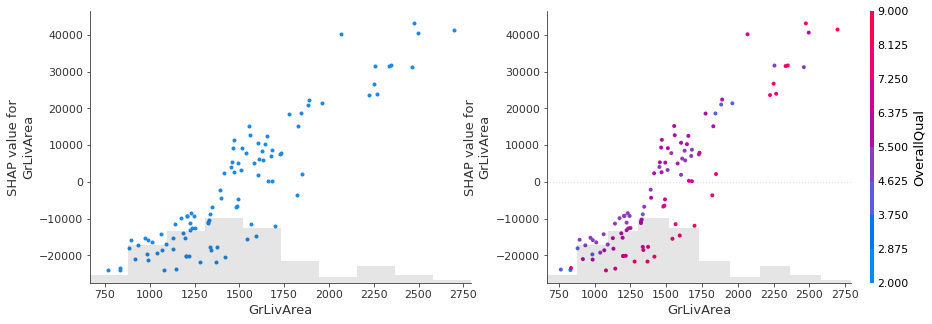

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
shap.plots.scatter(shap_values[:, "GrLivArea"], ax=axes[0], show=False)
shap.plots.scatter(
    shap_values[:, "GrLivArea"], color=shap_values, ax=axes[1], show=False
)
plt.show()


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Scatter Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    This <code>scatter</code> plot is a simple dependence scatter plot. There we have all the single observations we passed to the explainer and related to a chosen feature. The x-axis represents the feature value, and the y-axis shows the Shapley value related to that specific sample. Moreover, <code>shap</code> shows distribution of the feature at the bottom of the plot.
</p>
</blockquote>

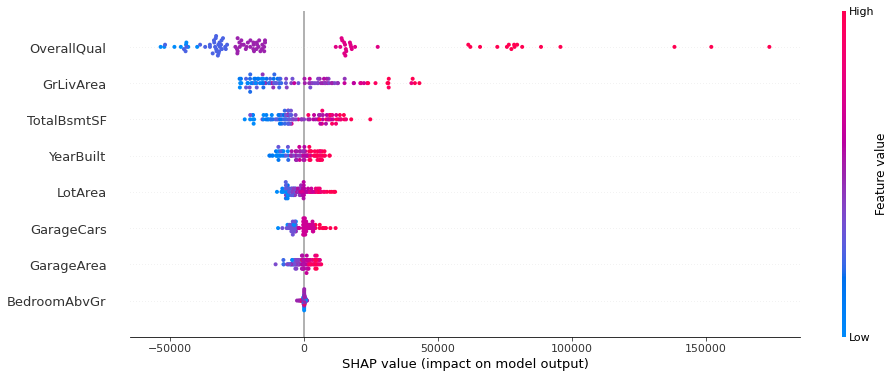

In [ ]:
shap.plots.beeswarm(shap_values, plot_size=(15, 6))


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Beeswarm Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    There we have the <code>beeswarm</code> plot. <b>Generally, this kind of plot shows the features' importance with their impact on the model.</b> Each instance we passed to the explainer is represented by a single dot. The position of that dot on the x-axis is specified by the Shapley value. As you can see, these dots resemble something like a distribution of Shapley values. 
</p>
</blockquote>

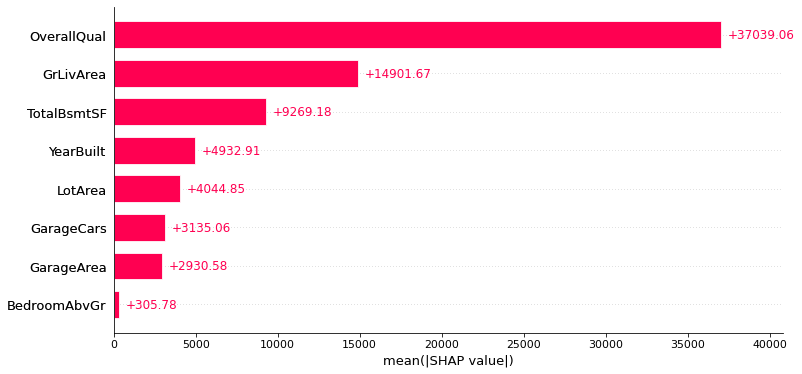

In [ ]:
shap.plots.bar(shap_values, show=False)
plt.gcf().set_size_inches(12, 6)


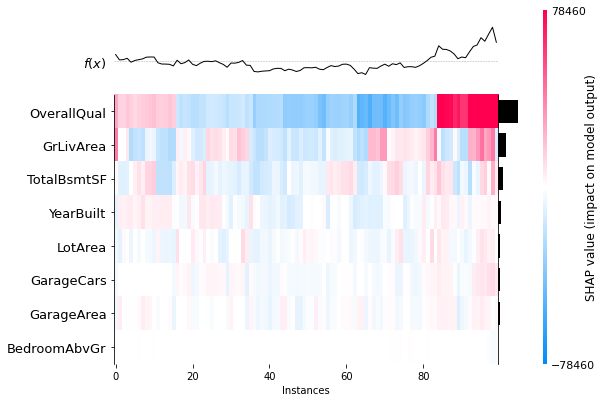

In [ ]:
shap.plots.heatmap(shap_values)

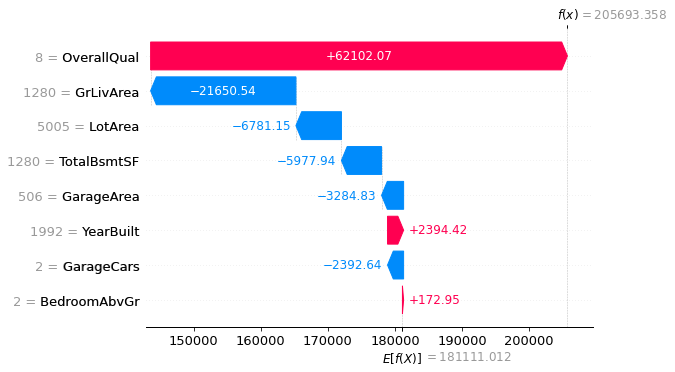

In [ ]:
shap.plots.waterfall(shap_values[4])

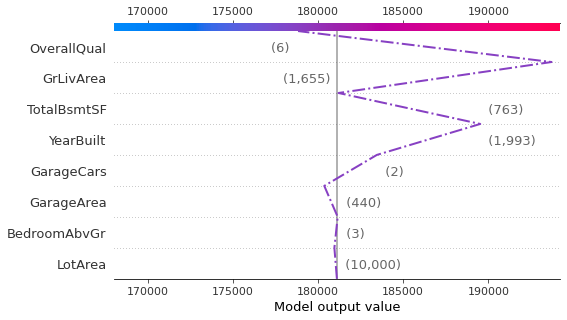

In [ ]:
shap.decision_plot(
    tree_explainer.expected_value,
    shap_values.values[5],
    features=X_house_prices_test.iloc[[5]],
    feature_names=feature_names,
    highlight=0,
)
